In [1]:
# in this notebook I try the following architecture
# Input-ExU-1-ExU-1-ExU-Output

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

In [4]:

def relu_n(x, n = 1):
    """ReLU activation clipped at n."""
    return tf.clip_by_value(x, 0, n)


In [5]:
class ExU(Layer):
    def __init__(self, units):
        super(ExU, self).__init__()
        self.units = units
        self._w_initializer = tf.initializers.TruncatedNormal(
          mean=4.0, stddev=0.5)
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer=self._w_initializer,
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(1, self.units),
            # NOTE HERE I INCREASED THE STDDEV! FROM 0.5 to 1.5. THIS REALLY HELPED FIT THE EDGES!
            initializer=tf.initializers.TruncatedNormal(stddev=1.5),
            trainable=True
        )
        
    def call(self, inputs):
        
#         this tile is row_stack tf.shape(x)[0] times
        centre = tf.tile(self.b, [tf.shape(inputs)[0], 1])
        return relu_n(tf.math.exp(self.w) * (inputs - centre))
#         return tf.matmul(inputs, self.w) + self.b

In [6]:
def plot_prediction_and_error(x, y, model=None, yhat=None):
    if model:
        yhat = model.predict(x)

    yRes = y - yhat
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    axes[0].plot(x, y)
    axes[0].plot(x, yhat)
    axes[1].plot(x, yRes)
    plt.show()
    plt.close()

In [7]:
def gen_test_data(stdev=0.1):
#     x = np.linspace(-np.pi/2., np.pi/2., 100)
    x = np.linspace(-1, 1, 100)[:,np.newaxis]
    y = np.cos(20*x) + np.sin(10*x)
#     y = np.cos(50*x) + np.sin(5*x)

    noise = np.random.normal(0, stdev, size=x.shape)

    return x, y + noise

x, y = gen_test_data(stdev=0.5)

In [8]:
import pugna.data

def preproc(data, method="MinMaxScaler", feature_range=(-1,1)):
    scalers = pugna.data.make_scalers(data, method=method, feature_range=feature_range)
    data_scaled = pugna.data.apply_scaler(data, scalers)
    return data_scaled, scalers

In [22]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import os



def resample_data(X, y, xmin=None, xmax=None, npts=1000, k=1):

    if xmin is None:
        xmin = X[0]
    if xmax is None:
        xmax = X[-1]
    mask = (X >= xmin) & (X <= xmax)

    iy = IUS(X[mask], y[mask], k=k)

    Xnew = np.linspace(xmin, xmax, npts)

    return Xnew, iy(Xnew)


def download_and_load_data():
    if os.path.exists("scaled_data_to_fit.txt") is False:
        os.system(
            "curl https://gitlab.com/SpaceTimeKhantinuum/ml/-/raw/master/nn-fitting/1d-fitting/scaled_data_to_fit.txt -O "
        )

    Xy = np.loadtxt("scaled_data_to_fit.txt")
    # sort by X
    X_raw, y_raw = Xy[np.argsort(Xy[:, 0])].T

    return X_raw, y_raw


x, y = download_and_load_data()

x, y = resample_data(x, y, xmin=None, xmax=None, npts=45, k=1)
# x, y = resample_data(x, y, xmin=None, xmax=None, npts=150, k=1)
# x, y = resample_data(x, y, xmin=None, xmax=None, npts=350, k=1)

x = x[:, np.newaxis]
y = y[:, np.newaxis]


x, x_val, y, y_val = train_test_split(x, y, test_size=0.25)

def sort_two_array_by_col(x, y, col):
    arr = np.column_stack((x, y))
    arr = arr[arr[:,col].argsort()]
    x = arr[:,0][:, np.newaxis]
    y = arr[:,1][:, np.newaxis]

    return x, y

x, y = sort_two_array_by_col(x, y, 0)
x_val, y_val = sort_two_array_by_col(x_val, y_val, 0)


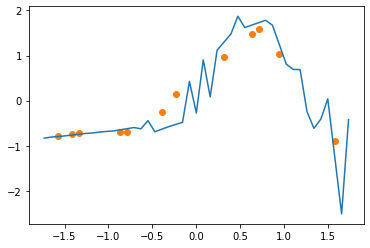

In [23]:
plt.figure()
plt.plot(x, y)
plt.scatter(x_val, y_val, c='C1')
plt.show()
plt.close()

In [180]:
def get_new_model(x, y, verbose=True, batch_size=None, epochs=1000, validation_data=None):
    if batch_size is None:
        batch_size = x.shape[0]
        
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        ExU(500),
        tf.keras.layers.Dense(1),
        ExU(500),
        tf.keras.layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001, amsgrad=True)
    model.compile(loss='mse', optimizer=optimizer)
    
    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)
    
    return history, model

In [181]:
%%time
history1, model1 = get_new_model(x, y, epochs=1000, validation_data=(x_val, y_val))

Epoch 1/1000
1/1 [==============================] - 0s 72ms/step - loss: 1.5699 - val_loss: 0.8080
Epoch 2/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0701 - val_loss: 0.7514
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.9250 - val_loss: 0.9724
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.9256 - val_loss: 1.0688
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.9940 - val_loss: 1.1436
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 1.0568 - val_loss: 1.1804
Epoch 7/1000
1/1 [==============================] - 0s 20ms/step - loss: 1.0976 - val_loss: 1.0068
Epoch 8/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.8683 - val_loss: 0.9112
Epoch 9/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.8960 - val_loss: 0.6584
Epoch 10/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.8328 - val_loss: 0.5990
Epoch 11/

In [182]:
model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ex_u_14 (ExU)                (None, 500)               1000      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 501       
_________________________________________________________________
ex_u_15 (ExU)                (None, 500)               1000      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 501       
Total params: 3,002
Trainable params: 3,002
Non-trainable params: 0
_________________________________________________________________


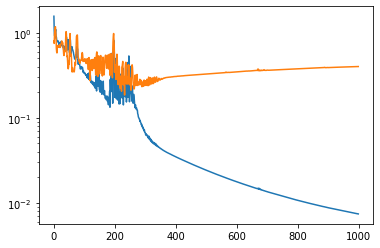

In [183]:
h1 = history1.history['loss']
h1_val = history1.history['val_loss']
plt.figure()
plt.plot(range(len(h1)), h1)
plt.plot(range(len(h1_val)), h1_val)
plt.yscale('log')

In [184]:
yhat = model1.predict(x)

In [185]:
yhat_val = model1.predict(x_val)

In [186]:
yRes = y-yhat 

In [187]:
yRes_val = y_val-yhat_val

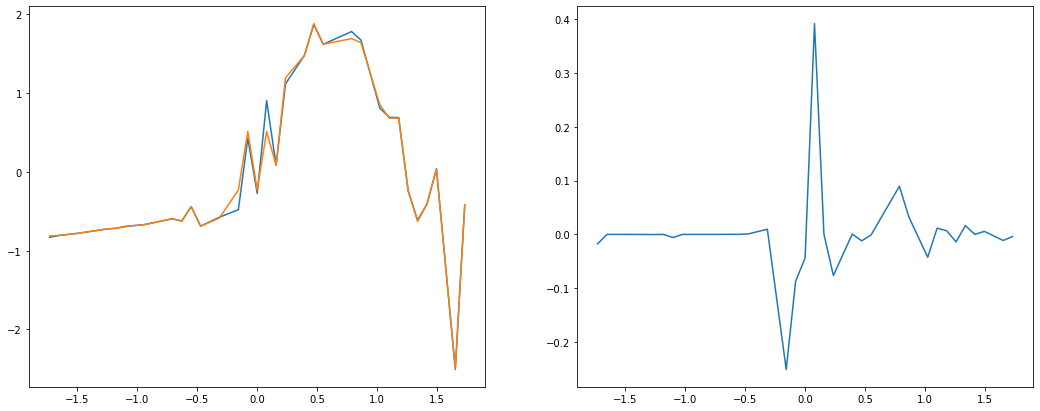

In [188]:
plot_prediction_and_error(x, y, model1)
# plot_prediction_and_error(x_val, y_val, model1)

In [189]:
plt.figure()
plt.scatter(x, tf.keras.losses.mean_squared_error(y, yhat) )
plt.yscale('log')
plt.ylim(1e-18, 1)

(1e-18, 1)

In [190]:
 def get_intermediate_output(model, layer_index, input_tensor):
    
    
    w = model.layers[layer_index].get_weights()[0]
    b = model.layers[layer_index].get_weights()[1]
    
    print(f"input: {input_tensor.shape}")
    print(f"w: {w.shape}")
    print(f"b: {b.shape}")
    
#     act = model.layers[layer_index].activation
    
#     out = act(tf.matmul(input_tensor, w) + b)

    
    out = relu_n(np.exp(w) * (input_tensor-b))

    
    print(f"out: {out.shape}")
    
    return out

In [191]:
input_tensor = tf.convert_to_tensor(x, dtype=tf.float32) 

In [192]:
model1.layers[0].get_weights()[0].shape

(1, 500)

In [193]:
model1.layers[0].get_weights()[1].shape

(1, 500)

In [194]:
model1.layers

In [195]:
output = get_intermediate_output(model1, 0, input_tensor) 

input: (33, 1)
w: (1, 500)
b: (1, 500)
out: (33, 500)


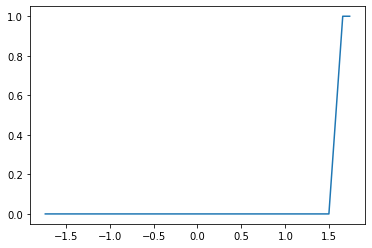

In [196]:
plt.figure()
plt.plot(input_tensor, output.numpy()[:,0])

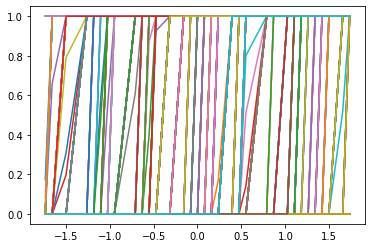

In [197]:
plt.figure()
for o in range(output.shape[1]):
    plt.plot(input_tensor, output.numpy()[:,o])

In [198]:
output.numpy().shape

(33, 500)

In [199]:
model1.layers[1].get_weights()[0].shape

(500, 1)

In [200]:
model1.layers[1].get_weights()[1]

array([-0.00819909], dtype=float32)

In [203]:
output2 = tf.matmul(output, model1.layers[1].get_weights()[0])+model1.layers[1].get_weights()[1]

In [204]:
plt.figure()
plt.plot(input_tensor, output2)
plt.plot(x, y)

In [205]:
output3 = get_intermediate_output(model1, 2, output2) 

input: (33, 1)
w: (1, 500)
b: (1, 500)
out: (33, 500)


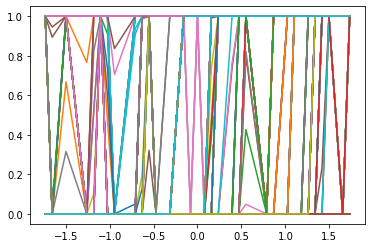

In [211]:
plt.plot(input_tensor, output3);

In [206]:
output4 = tf.matmul(output3, model1.layers[3].get_weights()[0])+model1.layers[3].get_weights()[1]

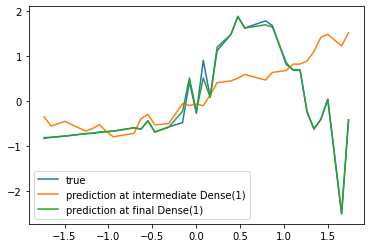

In [221]:
plt.figure()
plt.plot(x, y, label='true')
plt.plot(input_tensor, output2, label='prediction at intermediate Dense(1)')
plt.plot(input_tensor, output4, label='prediction at final Dense(1)')
plt.legend()

In [ ]:
# as we can see from abov the intermediate layer (orange) doesn't
# really show anything interesting in terms of following
# the data.

# nothing in terms of iteratively learning the data.

# if we just had a single layer of ExU with the same width it
# would be close to the actual data.